# <h1 id="title">LLMチュートリアル 2</h1>

## <h2 id="intro">概要</h2>
LLMチュートリアルの二つ目。RAG・量子化、重みの操作・ファインチューニングに踏み込む。

**目次**

- [LLMチュートリアル 2](#title)
  - [概要](#intro)
  - [量子化](#quant)

### import

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import re

import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline, AutoConfig

## <h2 id="quant">量子化</h2>

Hugging Faceのbitsandbytesライブラリを用いて簡単に8bitおよび4bit量子化を行うことができる。
🤗transformersのBitsAndBytesConfigをモデル読み込み時に指定することで簡単に量子化を行える。
[BitsAndBytesConfig](https://huggingface.co/docs/transformers/main/en/main_classes/quantization#transformers.BitsAndBytesConfig)

量子化の他に色々な数値表現を用いることができる。

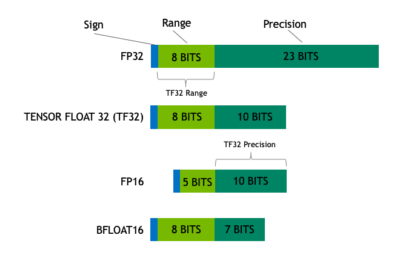

[図の引用](https://blogs.nvidia.com/blog/tensorfloat-32-precision-format/)

🤗transformersでは[QLoRA](https://arxiv.org/abs/2305.14314)で説明されている手法で量子化がなされている。
LLMでは外れ値を完全に無視した[量子化を行うと精度低下を招く](https://arxiv.org/abs/2208.07339)ことが指摘されており、
外れ値を反映できる量子化を用いることが一般的である。

また、現在ではLLMを個人で学習(時にはファインチューニング)することはGPUのVRAMや計算資源の不足により困難である。

よって量子化などでパラメータを削減したモデルをファインチューニングすることが現実的であるが、量子化モデルのファインチューニングは精度低下を招くことが通常であった。
QLoRAは量子化モデルを精度低下を最低限に抑えてファインチューニングする方法であり、Hugging Faceで主に採用されている量子化ファインチューニング手法である。

この章の量子化方法について理解することはファインチューニングを行う上でも重要になる。

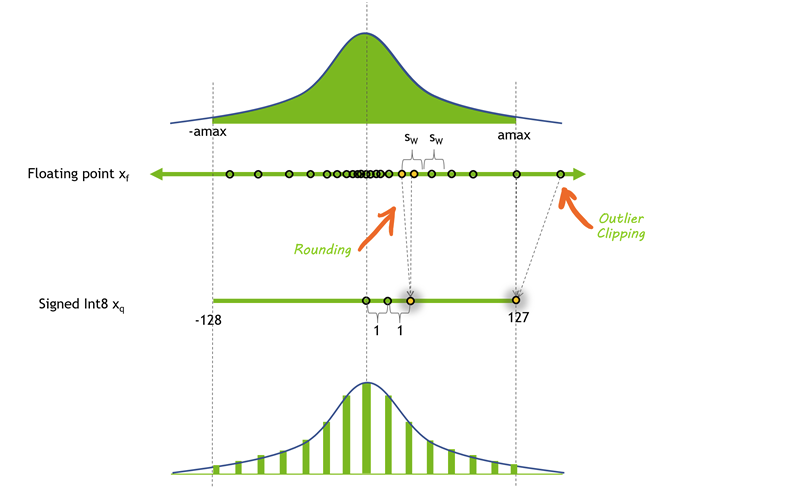

[図の引用](https://developer.nvidia.com/ja-jp/blog/mastering-llm-techniques-inference-optimization/)

1. **ゼロ点量子化(zero-point quantization)**

-1.0…1.0を-127…127のint8に量子化する時、0.3は量子化定数127を用いて、$0.3*127=38.1≈38$に量子化される。
元の値を得るには、$38/127=0.2992$で量子化誤差は$0.008$になる。
この誤差は逆伝播が進むたびに蓄積され、大きなパフォーマンスの低下を招く。

2. **絶対最大値量子化(absolute maximum (absmax) quantization)**

absmax量子化でFP16とそれに対応するint8を計算するには、元のFP16行列の最大値を取得し、最大値を127で割った値を量子化定数として量子化を行う。
unsigned int8の場合は最小値を減算して、絶対最大値でスケールする。

1、2の量子化手法が最も一般的な8bit量子化。

3. **[LLM.int8](https://arxiv.org/abs/2208.07339)**

LLMでは特定の閾値を超える外れ値がトランスフォーマー全体にわたる体系的なパターンから生じるため、外れ値を無視すると看過できない程度低下を招く。
このことから、外れ値の抽出して計算に反映することで精度低下を抑えるLLM.int8が提案された。
Hugging Faceでは標準でこの量子化が採用されている。

In [3]:
model_name = "google/gemma-2-9b-it"

**8bit量子化**

メモリには8bit数値表現で値が保存され、計算時は通常のfp32で計算が行われる。

In [4]:
# 8ビット量子化の設定
config_8bit = BitsAndBytesConfig(
    load_in_8bit=True,
    # llm_int8_threshold=6.0,
    # llm_int8_skip_modules=None,
    # llm_int8_enable_fp32_cpu_offload=False,
    # llm_int8_has_fp16_weight=False
)

**4bit量子化**



In [6]:
# 4ビット量子化の設定
config_4bit = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,        # 計算精度
    bnb_4bit_quant_type='nf4',          # 量子化タイプ ('fp4' or 'nf4')
    # bnb_4bit_use_double_quant=False,    # ダブル量子化
    # bnb_4bit_quant_storage=None         # 量子化のストレージタイプ
)

### モデル・トークナイザー読み込み

In [7]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True,
    local_files_only=True,
    torch_dtype=torch.float16, # torch.float32 torch.bfloat16
    quantization_config=config_4bit, # 量子化設定の読み込み
    device_map="auto"
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [8]:
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    local_files_only=True
)

量子化できないモデルもあるようなので、量子化がうまくいかない時はいかのメソッドを実行して量子化可能か確認する。

In [10]:
model.is_quantized

True

量子化手法も確認できる。

In [11]:
model.quantization_method

<QuantizationMethod.BITS_AND_BYTES: 'bitsandbytes'>

テキスト生成用のクラスを定義。

In [17]:
class llm_chat:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        
        self.messages = []
        self.talk_count = 0
        self.generated_text = None

    def strip_model_output(self, generated_text):
        """モデルの出力を取り出す関数

        Parameters
        ----------
        generated_text : str
            モデルが出力した(プロンプトを含んだ)そのままの文字列

        Returns
        -------
        str
            モデルが出力した文字列
        """
        matches = re.findall(r'<start_of_turn>model(.*?)<end_of_turn>', generated_text, re.DOTALL)
        
        # 結果を表示
        if matches:
            model_response = matches[-1].strip()  # 最後のマッチを取得
        else:
            print("該当するテキストが見つかりませんでした。")
            model_response = ""  # 該当がない場合は空文字列を返す
        
        return model_response

    def ensure_end_tokens(self, generated_text):
        """出力に<end_of_turn><eos>を追加する関数

        Parameters
        ----------
        generated_text : str
            モデルが出力した文字列

        Returns
        -------
        str
            修正された文字列
        """
        if not generated_text.endswith("<end_of_turn>"):
            generated_text += "<end_of_turn>"
        if not generated_text.endswith("<eos>"):
            generated_text += "<eos>"
        
        return generated_text
        
    def generate(self, input, max_new_tokens=256, forget_flag=False):
        if forget_flag:
            self.messages = [{"role": "user", "content": f"{input}"}]
        else:
            self.messages = self.messages + [{"role": "user", "content": f"{input}"}]
        
        input_ids = self.tokenizer.apply_chat_template(self.messages, return_tensors="pt", return_dict=True, add_generation_prompt=True).to("cuda")
        outputs = self.model.generate(**input_ids, max_new_tokens=max_new_tokens, eos_token_id=tokenizer.eos_token_id)
        self.generated_text = self.ensure_end_tokens(self.tokenizer.decode(outputs[0]))
        
        model_output = self.strip_model_output(self.generated_text)
        self.messages = self.messages + [{"role": "model", "content": f"{model_output}"}]
        
        print(model_output)


class llm_chat_sys(llm_chat):
    def __init__(self, model, tokenizer):
        super().__init__(model, tokenizer)
        
    
    def set_system_prompt(self, system_prompt):
        self.messages = [{"role": "system", "content": f"{system_prompt}"}]
    
    def change_system_prompt(self, system_prompt):
        self.messages[0]["content"] = system_prompt
    
    def _convert_to_str(self, messages):
        conversation = "<start_of_turn>"
        for message in messages:
            conversation += f"{message['role']}\n {message['content']}<end_of_turn>\n<start_of_turn>"
        conversation += f"model \n"
        
        return conversation
        
    def generate(self, input, max_new_tokens=256, forget_flag=False):
        if forget_flag:
            self.messages = [{"role": "user", "content": f"{input}"}]
        else:
            self.messages = self.messages + [{"role": "user", "content": f"{input}"}]
        
        converted_messages = self._convert_to_str(self.messages)
        
        input_ids = self.tokenizer(converted_messages, return_tensors="pt").to("cuda")
        outputs = self.model.generate(**input_ids, max_new_tokens=max_new_tokens, eos_token_id=tokenizer.eos_token_id)
        self.generated_text = self.ensure_end_tokens(self.tokenizer.decode(outputs[0]))
        
        model_output = self.strip_model_output(self.generated_text)
        self.messages = self.messages + [{"role": "model", "content": f"{model_output}"}]
        
        print(model_output)
    

In [18]:
gemma_quant = llm_chat_sys(model=model, tokenizer=tokenizer)

In [19]:
gemma_quant.set_system_prompt(system_prompt="あなたは誠実で優秀な日本人のアシスタントです。")

In [20]:
gemma_quant.generate(input="元気ですか？")

元気です！ 

何かお手伝いできることはありますか？😊


量子化の解除は以下の関数。

In [21]:
model.dequantize()

The model is going to be dequantized in torch.float16 - if you want to upcast it to another dtype, make sure to pass the desired dtype when quantizing the model through `bnb_4bit_quant_type` argument of `BitsAndBytesConfig`


Gemma2ForCausalLM(
  (model): Gemma2Model(
    (embed_tokens): Embedding(256000, 3584, padding_idx=0)
    (layers): ModuleList(
      (0-41): 42 x Gemma2DecoderLayer(
        (self_attn): Gemma2Attention(
          (q_proj): Linear(in_features=3584, out_features=4096, bias=False)
          (k_proj): Linear(in_features=3584, out_features=2048, bias=False)
          (v_proj): Linear(in_features=3584, out_features=2048, bias=False)
          (o_proj): Linear(in_features=4096, out_features=3584, bias=False)
          (rotary_emb): Gemma2RotaryEmbedding()
        )
        (mlp): Gemma2MLP(
          (gate_proj): Linear(in_features=3584, out_features=14336, bias=False)
          (up_proj): Linear(in_features=3584, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=3584, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): Gemma2RMSNorm((3584,), eps=1e-06)
        (pre_feedforward_layernorm): Gemma2RMSNorm((3584,), 

In [22]:
gemma = llm_chat_sys(model=model, tokenizer=tokenizer)
gemma.set_system_prompt(system_prompt="あなたは誠実で優秀な日本人のアシスタントです。")

In [23]:
gemma.generate(input="元気ですか？")

元気です！ 

何かお手伝いできることはありますか？😊


## <h2 id="finetuning">ファインチューニング</h2>

事前学習済みのモデルを別のデータセットを用いて再トレーニングすることで微調整をかけることをファインチューニングという。
システムプロンプトやRAGと比較すると実施のコストが非常に大きい。

ファインチューニングによって新たな知識を獲得することは難易度が高く、口調やキャラクター付けの学習(特定の人物の口調を模倣するなど)などは比較的難易度が低い。

モデル全体のパラメータに再学習をかけることはコストが高いため、LoRAという手法を用いて追加したアダプタのみに学習を行う。

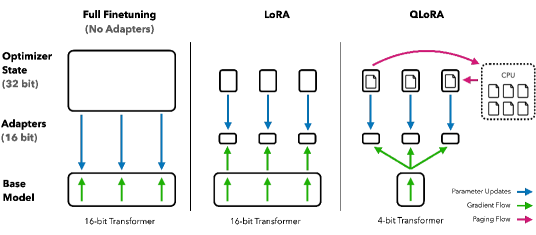

[図の引用](https://arxiv.org/abs/2305.14314)